In [1]:
# imports
import jax
# jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
from jax.random import PRNGKey as pkey
from jax.scipy.linalg import solve
# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from matplotlib.lines import Line2D
from tqdm.auto import tqdm
# plt.style.use("ggplot")
from importlib import reload

# Our libraries
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel, OperatorPDEModel,CholInducedRKHS,InducedOperatorModel
from plotting import plot_obs,plot_compare_error
from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs,
    GP_sampler,
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel
)

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM
from Optimizers.solvers_base import *


/home/juanfelipe/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Operator learning errors

In [18]:
def run_exp_opt_err(m,obs_pts,run):
    
    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = xy_pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = 2024
                                        )
                                        )
    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

    # Compute f = Pu for a given u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

    # Define the num of ghost points for each u
    num_grid_points = 10
    num_interior_points = 50

    # # Sample collocation points for f using random points different for every function
    # xy_ints,xy_bdys = sample_multiple_xy_grids_latin(
    #         num_functions = m,
    #         num_interior = num_interior_points,
    #         x_range = [0,1],
    #         y_range = [0,1],
    #         num_grid_x_bdy = num_grid_points,
    #         num_grid_y_bdy = num_grid_points,
    #         key = pkey(23)
    #     )
    
    # Sample collocation points for f using same uniform grid for every function
    xy_ints = tuple(build_xy_grid([0,1],[0,1],7,7)[0] for m in range(m))
    xy_bdys = tuple(build_xy_grid([0,1],[0,1],7,7)[1] for m in range(m))

    xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

    # List of number of observation points per u
    num_obs = [obs_pts]*m

    # Get (X^m, u^m(X^m))
    xy_obs,u_obs = build_u_obs_all(
        num_obs,
        xy_ints,
        xy_bdys,
        vmapped_u_true_functions,
        pkey(5)
    )

    # Build operator features
    def diff_x_op(k,index):
        return get_selected_grad(k,index,0)

    def diff_xx_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,0)

    def diff_y_op(k,index):
        return get_selected_grad(k,index,1)

    def diff_yy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,1),index,1)

    def diff_xy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,1)

    feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_operators = (eval_k,)
    u_models = tuple([CholInducedRKHS(
        xy_all[i],
        u_operators,
        k_u
        ) for i in range(m)])
    
    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = xy_ints


    rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

    all_u_params_init = tuple([
        model.get_fitted_params(obs_loc,obs_val)
        for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(
        model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for xy_int,model,model_params in zip(xy_ints,u_models,all_u_params_init) ])
    
    grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])
    
    # P kernel
    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
    k_P_x_part = get_gaussianRBF(0.4)
    
    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
        

    # P object        
    P_model = InducedOperatorModel(grid_features_u_init,k_P)
    num_P_params = len(grid_features_u_init)

    # P, u, f object
    collocation_points = xy_ints
    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
        num_P_operator_params = num_P_params
    )

    ### Optimize LM - new

    # Initialize
    rhs_values = tuple(rhs_func(int_points) for rhs_func,int_points in zip(rhs_functions,collocation_points))
    print(jnp.hstack(rhs_values).shape)
    print(grid_features_u_init.shape)
    P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values))
    params_init = jnp.hstack(list(all_u_params_init)+[P_init])
    # params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_ints[0]))])
    
    
    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                         line_search_increase_ratio = 1.4,
                         print_every = 100,
                         tol = 1e-10)
    # Run CholeskyLM 
    params,convergence_data = CholeskyLM(
        params_init.copy(),
        EqnModel,
        beta = 1e-8,
        optParams = optparams
    )
    
    p_adjusted,refine_convergence_data = SVD_LM(
        params,
        EqnModel,
        beta = 1e-13,
        optParams = optparams
    )

    # Optimized parameters
    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)


    ### Errors loop

    # Testing grid
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T
    
    # S_train for 1.5 step method
    # model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)
    model_grid_features_all = jnp.vstack([EqnModel.single_eqn_features(u_model,u_params,eval_points) 
                                          for u_model,u_params,eval_points in zip(
                                            EqnModel.u_models,
                                            u_sols,
                                            EqnModel.collocation_points)])

    # S_train for 2 step method
    #init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
    init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_model,u_params,eval_points) 
                                          for u_model,u_params,eval_points in zip(
                                            EqnModel.u_models,
                                            all_u_params_init,
                                            EqnModel.collocation_points)])

    # Backward operator error
    
    # Simulate u
    M = 3
    #M = 20
    kernel_GP = get_gaussianRBF(0.5) # Same regularity as training u's
    # Sample M training functions from GP(0,K)
    u_news_ = GP_sampler(num_samples = M,
                    X = xy_pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    u_news = tuple([jax.vmap(u_new_) for u_new_ in u_news_]) # vmap'ed
    f_news = tuple([jax.vmap(get_rhs_darcy(u_new_)) for u_new_ in u_news_]) #vmap'ed

    # 1_5 step

    # Collocation points where to solve for \hat P (u) = f_new
    #num_interior_points = 500
    num_interior_points = 256
    num_grid_points = 20
    # Sample collocation points for learning u
    xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
            num_functions = 1,
            num_interior = num_interior_points,
            x_range = [0,1],
            y_range = [0,1],
            num_grid_x_bdy = num_grid_points,
            num_grid_y_bdy = num_grid_points,
            key = pkey(24)
        )
    # Boundary pairs
    xy_bdy = xy_boundarys[0]
    # Interior pairs (where PDE is satisfied)
    xy_int = xy_interiors[0]
    # Union of xy_bdy
    xy_all = jnp.vstack([xy_int,xy_bdy])

    # u_new object
    u_model = CholInducedRKHS(
        xy_all,
        feature_operators,
        k_u
        )

    def get_u_pde_adj(u_new,f_new,method):
        
        @jit
        def get_pred_hatP(input_features):
            # return P_model.predict_new(input_features,model_grid_features_all,P_sol)
            return P_model.predict(input_features,P_sol)
        
        @jit
        def get_pred_hatP2step(input_features):
            # init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
            init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_model,u_params,eval_points) 
                                          for u_model,u_params,eval_points in zip(
                                            EqnModel.u_models,
                                            all_u_params_init,
                                            EqnModel.collocation_points)])
            rhs_stacked = EqnModel.stacked_collocation_rhs
            P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
            return P_model.predict(input_features,P_params_naive)

        

        new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


        class PdeModel():

            datafit_weight = 50.

            @jit
            def get_grid_features(u_params):
                evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
                grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
                return jnp.hstack([xy_int,grid_features])
            
            @jit
            def get_grid_target(u_params):
                return f_new(xy_int)
            
            @jit
            def eval_obs_points(u_params):
                return u_model.point_evaluate(xy_bdy,u_params)
            
            @jit
            def datafit_residual(u_params):
                obs_preds = PdeModel.eval_obs_points(u_params)
                return new_obs - obs_preds
            
            @jit
            def equation_residual(u_params):
                P_features = PdeModel.get_grid_features(u_params)
                P_model_preds = jnp.where(method == 1, get_pred_hatP(P_features), get_pred_hatP2step(P_features))
                ugrid_target = PdeModel.get_grid_target(u_params)
                return (ugrid_target - P_model_preds)
            
            @jit
            def F(u_params):
                eqn_res = PdeModel.equation_residual(u_params)
                data_res = PdeModel.datafit_residual(u_params)
                return jnp.hstack([
                    PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                    eqn_res/jnp.sqrt(len(eqn_res))
                    ])
            
            jac = jit(jacrev(F))

            def loss(u_params):
                return jnp.linalg.norm(PdeModel.F(u_params))**2
            
            @jit
            def damping_matrix(u_params):
                return u_model.kmat+1e-5 * diagpart(u_model.kmat)
        
        # Optimize
        new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

        # Optimizer hyperparameters
        optparams = LMParams(max_iter = 301,
                         line_search_increase_ratio = 1.4,
                         print_every = 100,
                         tol = 1e-10)
        
        u_params_pde, _ = CholeskyLM(
            new_u_init.copy(),
            PdeModel,
            beta = 0,
            optParams = optparams
        )

        # u_params_pde,_ = CholeskyLM(
        #     new_u_init.copy(),
        #     PdeModel,
        #     beta = 0.,
        #     max_iter = 101,
        #     init_alpha=0.05,
        #     line_search_increase_ratio=1.4,
        #     print_every = 10
        # )

        # u_pde_adj,_ = SVD_LM(u_params_pde,PdeModel,1e-1,150)

        u_pde_adj,_ = SVD_LM(
        u_params_pde,
        EqnModel,
        beta = 1e-13,
        optParams = optparams
    )

        return u_pde_adj


    
    # Define fine grid to test
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
    xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    true = [u_new(xy_fine) for u_new in u_news]

    pred1_5 = [
        u_model.point_evaluate(xy_fine,get_u_pde_adj(u_new,f_new,method=1))
        for u_new,f_new in zip(u_news,f_news)
    ]    

    pred2 = [
        u_model.point_evaluate(xy_fine,get_u_pde_adj(u_new,f_new,method=2))
        for u_new,f_new in zip(u_news,f_news)
    ]

    i_opt_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    i_opt_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return i_opt_1_5, i_opt_2

In [19]:
a, b = run_exp_opt_err(m = 2, obs_pts = 4, run = 2)

(50,)
(50, 8)


 17%|█▋        | 52/301 [00:02<00:07, 31.58it/s]

Iteration 0, loss = 5.98e-06, gradnorm = 1.298e-05, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 5.98e-06, gradnorm = 6.041e-06, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 5.98e-06, gradnorm = 5.075e-06, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 5.98e-06, gradnorm = 4.499e-06, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 5.98e-06, gradnorm = 4.1e-06, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 5.98e-06, gradnorm = 3.813e-06, alpha = 1.005, improvement_ratio = 1.0


 64%|██████▍   | 193/301 [00:02<00:01, 75.04it/s] 


Iteration 100, loss = 3.989e-06, gradnorm = 0.00104, alpha = 5.581e-07, improvement_ratio = 0.7643


  3%|▎         | 10/301 [00:02<00:47,  6.17it/s]

Iteration 0, loss = 6.173e-08, gradnorm = 2.158e-07, alpha = 2.5, improvement_ratio = 1.001
Iteration 1, loss = 6.173e-08, gradnorm = 2.012e-07, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 6.173e-08, gradnorm = 1.966e-07, alpha = 1.736, improvement_ratio = 1.002
Iteration 3, loss = 6.173e-08, gradnorm = 1.936e-07, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 6.173e-08, gradnorm = 1.914e-07, alpha = 1.206, improvement_ratio = 0.9974
Iteration 5, loss = 6.173e-08, gradnorm = 1.897e-07, alpha = 1.005, improvement_ratio = 0.9992


 39%|███▉      | 118/301 [00:03<00:02, 86.11it/s]

Iteration 100, loss = 3.359e-09, gradnorm = 8.395e-05, alpha = 3.622e-08, improvement_ratio = 0.8104


  3%|▎         | 9/301 [00:27<10:51,  2.23s/it]  

Iteration 0, loss = 0.05717, gradnorm = 989.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.03695, gradnorm = 0.002692, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.0307, gradnorm = 0.001101, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.02734, gradnorm = 0.000686, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.02504, gradnorm = 0.0005162, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.02323, gradnorm = 0.0004197, alpha = 1.005, improvement_ratio = 1.0


 38%|███▊      | 115/301 [00:28<00:03, 47.39it/s]

Iteration 100, loss = 0.001102, gradnorm = 8.078e-06, alpha = 3.019e-08, improvement_ratio = 1.0


 71%|███████   | 214/301 [00:30<00:01, 82.75it/s]

Iteration 200, loss = 0.0006516, gradnorm = 2.921e-05, alpha = 8.333e-09, improvement_ratio = 1.001


100%|██████████| 301/301 [00:31<00:00,  9.65it/s]


Iteration 300, loss = 0.000602, gradnorm = 2.041e-05, alpha = 8.333e-09, improvement_ratio = 0.9996


  3%|▎         | 10/301 [00:02<00:49,  5.94it/s]

Iteration 0, loss = 1.248e+11, gradnorm = 2.62e+09, alpha = 2.5, improvement_ratio = 0.9119
Iteration 1, loss = 3.901e+09, gradnorm = 6.713e+08, alpha = 2.083, improvement_ratio = 0.9688
Iteration 2, loss = 1.304e+08, gradnorm = 8.054e+07, alpha = 1.736, improvement_ratio = 0.9669
Iteration 3, loss = 2.382e+07, gradnorm = 2.721e+07, alpha = 1.447, improvement_ratio = 0.8236
Iteration 4, loss = 1.481e+07, gradnorm = 9.463e+06, alpha = 1.447, improvement_ratio = 0.3893
Iteration 5, loss = 6.313e+06, gradnorm = 6.829e+06, alpha = 1.447, improvement_ratio = 0.5934


 39%|███▉      | 117/301 [00:03<00:02, 89.42it/s]

Iteration 100, loss = 7.874e+03, gradnorm = 6.982e+03, alpha = 0.2337, improvement_ratio = 0.8111


 71%|███████   | 214/301 [00:04<00:00, 100.48it/s]

Iteration 200, loss = 1.482e+03, gradnorm = 2.611e+03, alpha = 0.03145, improvement_ratio = 0.7617


100%|██████████| 301/301 [00:05<00:00, 58.01it/s] 


Iteration 300, loss = 210.6, gradnorm = 982.1, alpha = 0.008777, improvement_ratio = 0.7907


  3%|▎         | 9/301 [00:27<10:50,  2.23s/it]  

Iteration 0, loss = 0.0934, gradnorm = 975.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.06355, gradnorm = 0.002759, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.05071, gradnorm = 0.001479, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.04381, gradnorm = 0.000981, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.0396, gradnorm = 0.0007075, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.03672, gradnorm = 0.0005433, alpha = 1.005, improvement_ratio = 1.0


 39%|███▉      | 117/301 [00:28<00:03, 47.73it/s]

Iteration 100, loss = 0.001552, gradnorm = 4.464e-06, alpha = 3.019e-08, improvement_ratio = 1.0


 72%|███████▏  | 216/301 [00:30<00:01, 82.51it/s]

Iteration 200, loss = 0.0009212, gradnorm = 6.398e-05, alpha = 8.333e-09, improvement_ratio = 1.0


100%|██████████| 301/301 [00:31<00:00,  9.67it/s]


Iteration 300, loss = 0.0008347, gradnorm = 3.134e-05, alpha = 8.333e-09, improvement_ratio = 1.005


  4%|▍         | 12/301 [00:02<00:41,  6.98it/s]

Iteration 0, loss = 8.028e+11, gradnorm = 7.77e+09, alpha = 2.5, improvement_ratio = 0.9177
Iteration 1, loss = 6.21e+10, gradnorm = 1.906e+09, alpha = 2.083, improvement_ratio = 0.9227
Iteration 2, loss = 6.162e+08, gradnorm = 5.892e+08, alpha = 1.736, improvement_ratio = 0.9901
Iteration 3, loss = 2.163e+07, gradnorm = 2.525e+07, alpha = 1.447, improvement_ratio = 0.9672
Iteration 4, loss = 1.302e+07, gradnorm = 7.86e+06, alpha = 1.447, improvement_ratio = 0.4176
Iteration 5, loss = 8.163e+06, gradnorm = 7.267e+06, alpha = 1.447, improvement_ratio = 0.396


 38%|███▊      | 113/301 [00:03<00:02, 83.96it/s]

Iteration 100, loss = 1.453e+04, gradnorm = 8.42e+03, alpha = 0.4038, improvement_ratio = 0.7846


 73%|███████▎  | 220/301 [00:04<00:00, 100.30it/s]

Iteration 200, loss = 3.657e+03, gradnorm = 3.945e+03, alpha = 0.06521, improvement_ratio = 0.7224


100%|██████████| 301/301 [00:05<00:00, 56.96it/s] 


Iteration 300, loss = 969.3, gradnorm = 1.358e+03, alpha = 0.02621, improvement_ratio = 0.6762


  3%|▎         | 9/301 [00:28<11:01,  2.27s/it]  

Iteration 0, loss = 0.1862, gradnorm = 1.214e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.152, gradnorm = 0.003148, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.1348, gradnorm = 0.001682, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.1234, gradnorm = 0.001264, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.1146, gradnorm = 0.001029, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.1072, gradnorm = 0.000884, alpha = 1.005, improvement_ratio = 1.0


 38%|███▊      | 115/301 [00:29<00:03, 46.91it/s]

Iteration 100, loss = 0.004965, gradnorm = 2.57e-05, alpha = 3.019e-08, improvement_ratio = 1.0


 71%|███████   | 214/301 [00:30<00:01, 79.95it/s]

Iteration 200, loss = 0.002855, gradnorm = 7.93e-05, alpha = 8.333e-09, improvement_ratio = 1.002


100%|██████████| 301/301 [00:31<00:00,  9.50it/s]


Iteration 300, loss = 0.002741, gradnorm = 8.936e-05, alpha = 8.333e-09, improvement_ratio = 0.996


  3%|▎         | 10/301 [00:02<00:47,  6.13it/s]

Iteration 0, loss = 9.705e+12, gradnorm = 6.953e+10, alpha = 2.5, improvement_ratio = 0.9408
Iteration 1, loss = 5.805e+11, gradnorm = 1.055e+10, alpha = 2.083, improvement_ratio = 0.9402
Iteration 2, loss = 1.987e+10, gradnorm = 1.385e+09, alpha = 1.736, improvement_ratio = 0.9658
Iteration 3, loss = 8.011e+08, gradnorm = 2.152e+08, alpha = 1.447, improvement_ratio = 0.9597
Iteration 4, loss = 6.929e+06, gradnorm = 7.31e+07, alpha = 1.206, improvement_ratio = 0.9921
Iteration 5, loss = 3.096e+06, gradnorm = 6.048e+06, alpha = 1.206, improvement_ratio = 0.6019


 38%|███▊      | 114/301 [00:03<00:02, 89.14it/s]

Iteration 100, loss = 3.92e+04, gradnorm = 2.599e+04, alpha = 0.4038, improvement_ratio = 0.6805


 73%|███████▎  | 220/301 [00:04<00:00, 97.84it/s]

Iteration 200, loss = 7.459e+03, gradnorm = 1.015e+04, alpha = 0.1352, improvement_ratio = 0.7689


100%|██████████| 301/301 [00:05<00:00, 58.19it/s]


Iteration 300, loss = 1.733e+03, gradnorm = 2.818e+03, alpha = 0.0182, improvement_ratio = 0.7346


  3%|▎         | 8/301 [00:28<12:30,  2.56s/it]  

Iteration 0, loss = 0.01072, gradnorm = 1.067e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.005542, gradnorm = 0.001769, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.004253, gradnorm = 0.0005629, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.003483, gradnorm = 0.0003636, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.002953, gradnorm = 0.0002779, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.002565, gradnorm = 0.0002199, alpha = 1.005, improvement_ratio = 1.0


 37%|███▋      | 111/301 [00:29<00:03, 49.19it/s]

Iteration 100, loss = 0.0001627, gradnorm = 1.568e-06, alpha = 3.019e-08, improvement_ratio = 1.0


 71%|███████▏  | 215/301 [00:30<00:01, 75.78it/s]

Iteration 200, loss = 8.726e-05, gradnorm = 2.478e-05, alpha = 8.333e-09, improvement_ratio = 1.005


100%|██████████| 301/301 [00:31<00:00,  9.41it/s]


Iteration 300, loss = 8.349e-05, gradnorm = 4.213e-05, alpha = 8.333e-09, improvement_ratio = 0.9978


  4%|▎         | 11/301 [00:02<00:41,  6.99it/s]

Iteration 0, loss = 2.547e+09, gradnorm = 1.575e+08, alpha = 2.5, improvement_ratio = 0.9347
Iteration 1, loss = 1.692e+08, gradnorm = 2.604e+07, alpha = 2.083, improvement_ratio = 0.9336
Iteration 2, loss = 3.976e+06, gradnorm = 6.196e+06, alpha = 1.736, improvement_ratio = 0.9769
Iteration 3, loss = 1.25e+05, gradnorm = 8.719e+05, alpha = 1.447, improvement_ratio = 0.9778
Iteration 4, loss = 4.496e+04, gradnorm = 1.139e+05, alpha = 1.206, improvement_ratio = 0.8057
Iteration 5, loss = 2.818e+04, gradnorm = 4.85e+04, alpha = 1.206, improvement_ratio = 0.6203


 38%|███▊      | 115/301 [00:03<00:02, 89.50it/s]

Iteration 100, loss = 26.67, gradnorm = 117.2, alpha = 0.007314, improvement_ratio = 0.6854


 71%|███████   | 213/301 [00:04<00:00, 100.66it/s]

Iteration 200, loss = 1.103, gradnorm = 19.47, alpha = 0.0003956, improvement_ratio = 0.818


100%|██████████| 301/301 [00:05<00:00, 59.89it/s] 


Iteration 300, loss = 0.07825, gradnorm = 4.163, alpha = 4.437e-05, improvement_ratio = 0.7924


  3%|▎         | 8/301 [00:27<12:22,  2.53s/it]  

Iteration 0, loss = 0.02489, gradnorm = 1.025e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.01388, gradnorm = 0.002049, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.01014, gradnorm = 0.0008822, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.008469, gradnorm = 0.0005401, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.00766, gradnorm = 0.0003553, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.007221, gradnorm = 0.000249, alpha = 1.005, improvement_ratio = 1.0


 37%|███▋      | 111/301 [00:29<00:03, 49.44it/s]

Iteration 100, loss = 0.0001694, gradnorm = 1.658e-06, alpha = 3.019e-08, improvement_ratio = 1.0


 71%|███████▏  | 215/301 [00:30<00:01, 75.76it/s]

Iteration 200, loss = 8.731e-05, gradnorm = 2.072e-05, alpha = 8.333e-09, improvement_ratio = 0.9998


100%|██████████| 301/301 [00:31<00:00,  9.50it/s]


Iteration 300, loss = 8.259e-05, gradnorm = 2.327e-05, alpha = 8.333e-09, improvement_ratio = 1.0


  4%|▎         | 11/301 [00:02<00:42,  6.83it/s]

Iteration 0, loss = 2.532e+10, gradnorm = 8.638e+08, alpha = 2.5, improvement_ratio = 0.9401
Iteration 1, loss = 1.25e+09, gradnorm = 1.352e+08, alpha = 2.083, improvement_ratio = 0.9506
Iteration 2, loss = 5.809e+07, gradnorm = 2.373e+07, alpha = 1.736, improvement_ratio = 0.9536
Iteration 3, loss = 6.696e+05, gradnorm = 4.183e+06, alpha = 1.447, improvement_ratio = 0.9894
Iteration 4, loss = 4.73e+04, gradnorm = 1.953e+05, alpha = 1.206, improvement_ratio = 0.9825
Iteration 5, loss = 3.053e+04, gradnorm = 3.804e+04, alpha = 1.005, improvement_ratio = 0.9105


 39%|███▊      | 116/301 [00:03<00:02, 88.41it/s]

Iteration 100, loss = 176.7, gradnorm = 374.1, alpha = 0.01264, improvement_ratio = 0.7361


 70%|███████   | 212/301 [00:04<00:00, 100.58it/s]

Iteration 200, loss = 8.103, gradnorm = 55.2, alpha = 0.001417, improvement_ratio = 0.7657


100%|██████████| 301/301 [00:05<00:00, 59.25it/s] 


Iteration 300, loss = 0.5416, gradnorm = 10.06, alpha = 0.0001104, improvement_ratio = 0.6712


  3%|▎         | 8/301 [00:27<12:22,  2.53s/it]  

Iteration 0, loss = 0.06977, gradnorm = 1.326e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.05509, gradnorm = 0.002026, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.04908, gradnorm = 0.001028, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.04522, gradnorm = 0.0007465, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.0422, gradnorm = 0.0005982, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.03962, gradnorm = 0.0005008, alpha = 1.005, improvement_ratio = 1.0


 37%|███▋      | 111/301 [00:29<00:03, 49.26it/s]

Iteration 100, loss = 0.003662, gradnorm = 1.331e-05, alpha = 3.019e-08, improvement_ratio = 1.0


 71%|███████▏  | 215/301 [00:30<00:01, 75.68it/s]

Iteration 200, loss = 0.002574, gradnorm = 3.364e-05, alpha = 8.333e-09, improvement_ratio = 1.004


100%|██████████| 301/301 [00:31<00:00,  9.49it/s]


Iteration 300, loss = 0.002509, gradnorm = 6.375e-05, alpha = 8.333e-09, improvement_ratio = 0.9697


  4%|▎         | 11/301 [00:02<00:40,  7.08it/s]

Iteration 0, loss = 2.127e+12, gradnorm = 2.201e+10, alpha = 2.5, improvement_ratio = 0.9363
Iteration 1, loss = 1.332e+11, gradnorm = 3.535e+09, alpha = 2.083, improvement_ratio = 0.9374
Iteration 2, loss = 5.768e+09, gradnorm = 5.52e+08, alpha = 1.736, improvement_ratio = 0.9567
Iteration 3, loss = 4.697e+08, gradnorm = 9.083e+07, alpha = 1.447, improvement_ratio = 0.9186
Iteration 4, loss = 1.191e+07, gradnorm = 2.838e+07, alpha = 1.206, improvement_ratio = 0.975
Iteration 5, loss = 3.272e+05, gradnorm = 4.585e+06, alpha = 1.005, improvement_ratio = 0.983


 39%|███▉      | 117/301 [00:03<00:02, 89.65it/s]

Iteration 100, loss = 4.245e+03, gradnorm = 3.712e+03, alpha = 0.1947, improvement_ratio = 0.6597


 73%|███████▎  | 220/301 [00:04<00:00, 99.09it/s]

Iteration 200, loss = 1.099e+03, gradnorm = 2.783e+03, alpha = 0.02184, improvement_ratio = 0.7584


100%|██████████| 301/301 [00:05<00:00, 59.87it/s] 


Iteration 300, loss = 259.0, gradnorm = 1.042e+03, alpha = 0.01053, improvement_ratio = 0.7987


In [20]:
a

Array(94.32917385, dtype=float64)

In [21]:
b

Array(43.17142787, dtype=float64)

In [6]:
m = 2
obs_pts = 4
run = 2

# Sample m training functions from a GP
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = 2024
                                    )
                                    )
# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

# Define the num of ghost points for each u
num_grid_points = 10
num_interior_points = 50

# # Sample collocation points for f using random points different for every function
# xy_ints,xy_bdys = sample_multiple_xy_grids_latin(
#         num_functions = m,
#         num_interior = num_interior_points,
#         x_range = [0,1],
#         y_range = [0,1],
#         num_grid_x_bdy = num_grid_points,
#         num_grid_y_bdy = num_grid_points,
#         key = pkey(23)
#     )

# Sample collocation points for f using same uniform grid for every function
xy_ints = tuple(build_xy_grid([0,1],[0,1],7,7)[0] for m in range(m))
xy_bdys = tuple(build_xy_grid([0,1],[0,1],7,7)[1] for m in range(m))

xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(5)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)
u_models = tuple([CholInducedRKHS(
    xy_all[i],
    u_operators,
    k_u
    ) for i in range(m)])

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    model.get_fitted_params(obs_loc,obs_val)
    for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

grid_features_u_init = jnp.vstack([(
    model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model,model_params in zip(xy_ints,u_models,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])



### Optimize LM - new

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    



# Initialize
rhs_values = tuple(rhs_func(int_points) for rhs_func,int_points in zip(rhs_functions,collocation_points))
print(jnp.hstack(rhs_values).shape)
print(grid_features_u_init.shape)

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init)
                               

P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values))
params_init = jnp.hstack(list(all_u_params_init)+[P_init])
print(params_init.shape)
print(P_init.shape)
params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_ints[0]))])



# P, u, f object
collocation_points = xy_ints
EqnModel  = OperatorPDEModel(
    P_model,
    u_models,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = num_P_params
)


# Optimizer hyperparameters
optparams = LMParams(max_iter = 301,
                    line_search_increase_ratio = 1.4,
                    print_every = 100,
                    tol = 1e-10
                    )



(50,)
(50, 8)
(148,)
(50,)


In [36]:
# Run CholeskyLM 
params,convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 1e-8,
    optParams = optparams
)

p_adjusted,refine_convergence_data = SVD_LM(
    params,
    EqnModel,
    beta = 1e-13,
    optParams = optparams
)

# Optimized parameters
u_sols = EqnModel.get_u_params(p_adjusted)
P_sol = EqnModel.get_P_params(p_adjusted)


  0%|          | 0/301 [00:00<?, ?it/s]

Iteration 0, loss = 82.83, gradnorm = 23.75, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 12.33, gradnorm = 35.7, alpha = 2.083, improvement_ratio = 1.084
Iteration 2, loss = 5.053, gradnorm = 8.162, alpha = 1.736, improvement_ratio = 1.047
Iteration 3, loss = 3.189, gradnorm = 3.274, alpha = 1.447, improvement_ratio = 1.017
Iteration 4, loss = 2.311, gradnorm = 1.555, alpha = 1.206, improvement_ratio = 1.008
Iteration 5, loss = 1.711, gradnorm = 1.056, alpha = 1.005, improvement_ratio = 1.008
Iteration 100, loss = 2.417e-06, gradnorm = 0.0001554, alpha = 2.243e-07, improvement_ratio = 0.8121


  0%|          | 0/301 [00:00<?, ?it/s]

Iteration 0, loss = 6.173e-08, gradnorm = 2.158e-07, alpha = 2.5, improvement_ratio = 1.002
Iteration 1, loss = 6.173e-08, gradnorm = 2.012e-07, alpha = 2.083, improvement_ratio = 0.998
Iteration 2, loss = 6.173e-08, gradnorm = 1.966e-07, alpha = 1.736, improvement_ratio = 0.9998
Iteration 3, loss = 6.173e-08, gradnorm = 1.936e-07, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 6.173e-08, gradnorm = 1.914e-07, alpha = 1.206, improvement_ratio = 0.9986
Iteration 5, loss = 6.173e-08, gradnorm = 1.897e-07, alpha = 1.005, improvement_ratio = 1.002
Iteration 100, loss = 3.359e-09, gradnorm = 8.395e-05, alpha = 3.622e-08, improvement_ratio = 0.8104


In [3]:
err = {
    '1_5_mthd': {
        '2_obs': {'i_opt': []},
        '4_obs': {'i_opt': []},
        '6_obs': {'i_opt': []},
        '8_obs': {'i_opt': []},
        '10_obs': {'i_opt': []}
                  },
    '2_mthd':   {
        '2_obs': {'i_opt': []},
        '4_obs': {'i_opt': []},
        '6_obs': {'i_opt': []},
        '8_obs': {'i_opt': []},
        '10_obs': {'i_opt': []}
                }
}

In [ ]:
NUM_FUN_LIST = [2,4,6,8]
NUM_RUNS = 3
OBS_PTS_LIST = [2,4,6,8,10]
for obs_pt in OBS_PTS_LIST:
    for m in NUM_FUN_LIST:
        i_opt_1_5 = []
        i_opt_2 = []
        for run in range(NUM_RUNS):
            # Run
            res = run_exp_opt_err(m, obs_pt, run)
            # Append
            i_opt_1_5.append(res[0])
            i_opt_2.append(res[1])
        # Append each list    
        err['1_5_mthd'][f'{obs_pt}_obs']['i_opt'].append(i_opt_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_opt'].append(i_opt_2)   
    # Save after
    jnp.save('errors_opt/err_rndm_grids_246810_1_5', err)

In [4]:
err = jnp.load('errors_opt/err_unif_grids_246810_1_5.npy', allow_pickle=True).item()

In [5]:
err

{'1_5_mthd': {'2_obs': {'i_opt': [[Array(0.10706994, dtype=float64),
     Array(0.1065423, dtype=float64),
     Array(0.29683795, dtype=float64)],
    [Array(0.02172732, dtype=float64),
     Array(0.02458626, dtype=float64),
     Array(0.03781029, dtype=float64)],
    [Array(0.02312203, dtype=float64),
     Array(0.01615728, dtype=float64),
     Array(0.02212406, dtype=float64)],
    [Array(0.01051447, dtype=float64),
     Array(0.01901893, dtype=float64),
     Array(0.01916618, dtype=float64)]]},
  '4_obs': {'i_opt': [[Array(0.07332755, dtype=float64),
     Array(0.06205022, dtype=float64),
     Array(0.16891295, dtype=float64)],
    [Array(0.0245208, dtype=float64),
     Array(0.01701029, dtype=float64),
     Array(0.02572246, dtype=float64)],
    [Array(0.01164215, dtype=float64),
     Array(0.01476634, dtype=float64),
     Array(0.01542454, dtype=float64)],
    [Array(0.0106653, dtype=float64),
     Array(0.0129918, dtype=float64),
     Array(0.01416241, dtype=float64)]]},
  '6_obs

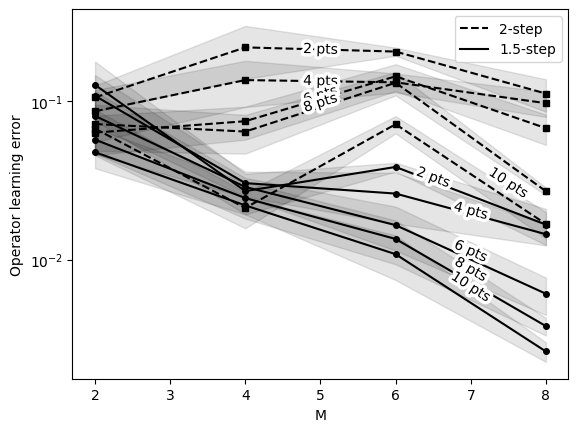

In [29]:
# Operator learning errors plot
NUM_FUN_LIST = [2,4,6,8]
NUM_RUNS = 3
OBS_PTS_LIST = [2,4,6,8,10]
# plt.title('Operator learning error: u_new ~ GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
# Colors
c2 = 'black'
c1 = 'black'
# 2-step method plot
for obs_pt in OBS_PTS_LIST:
    # 2 method
    mean_i_opt_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_opt'])])
    sd_i_opt_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_opt'])])
    # Plot 2 method
    plt.plot(ms, mean_i_opt_2, label = f'{obs_pt} pts', marker= 's', linestyle = 'dashed',markersize = 4, color = c2)
    plt.fill_between(ms, mean_i_opt_2 - sd_i_opt_2, mean_i_opt_2 + sd_i_opt_2, alpha=.1, color = c2)
    plt.yscale('log')
    plt.minorticks_off()
# 1-step method plot
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_opt_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_opt'])])
    sd_i_opt_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_opt'])])
    # Plot 1_5 method
    plt.plot(ms, mean_i_opt_1_5, label = f'{obs_pt} pts', marker= 'o',markersize = 4, color = c1)
    plt.fill_between(ms, mean_i_opt_1_5 - sd_i_opt_1_5, mean_i_opt_1_5 + sd_i_opt_1_5, alpha=.1, color = c1)
    plt.yscale('log')
    plt.minorticks_off()

plt.ylabel('Operator learning error')
plt.xlabel('M')


# adding labels to the plotlines
xvals_2step = [5]*4 + [7.5]
xvals_1step = [6.5]+[7]*4
xvals = xvals_2step + xvals_1step
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals = xvals)
# add legend box
legend_elements = [Line2D([0], [0], color= c2, linestyle='dashed', label='2-step'),
                   Line2D([0], [0], color= c1, label='1.5-step')]
plt.legend(handles = legend_elements, loc = 'upper right')
plt.show()

## In sample errors

In [2]:
def run_exp_i_smpl_err(m,obs_pts,run):
    
    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = xy_pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = 2024
                                        )
                                        )
    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

    # Compute f = Pu for a given u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

    # Define the num of ghost points for each u
    num_grid_points = 10
    num_interior_points = 50

    # Sample collocation points for f using random points different for every function
    xy_ints,xy_bdys = sample_multiple_xy_grids_latin(
            num_functions = m,
            num_interior = num_interior_points,
            x_range = [0,1],
            y_range = [0,1],
            num_grid_x_bdy = num_grid_points,
            num_grid_y_bdy = num_grid_points,
            key = pkey(23)
        )
    
    # # Sample collocation points for f using same uniform grid for every function
    # xy_ints = tuple(build_xy_grid([0,1],[0,1],7,7)[0] for m in range(m))
    # xy_bdys = tuple(build_xy_grid([0,1],[0,1],7,7)[1] for m in range(m))

    xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

    # List of number of observation points per u
    num_obs = [obs_pts]*m

    # Get (X^m, u^m(X^m))
    xy_obs,u_obs = build_u_obs_all(
        num_obs,
        xy_ints,
        xy_bdys,
        vmapped_u_true_functions,
        pkey(5)
    )

    # Build operator features
    def diff_x_op(k,index):
        return get_selected_grad(k,index,0)

    def diff_xx_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,0)

    def diff_y_op(k,index):
        return get_selected_grad(k,index,1)

    def diff_yy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,1),index,1)

    def diff_xy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,1)

    feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_operators = (eval_k,)
    u_models = tuple([CholInducedRKHS(
        xy_all[i],
        u_operators,
        k_u
        ) for i in range(m)])
    
    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = xy_ints

    rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

    all_u_params_init = tuple([
        model.get_fitted_params(obs_loc,obs_val)
        for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(
        model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for xy_int,model,model_params in zip(xy_ints,u_models,all_u_params_init) ])
    
    # P kernel
    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
    k_P_x_part = get_gaussianRBF(0.4)
    @vectorize_kfunc
    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])

    # P object        
    P_model = OperatorModel(k_P)

    # P, u, f object
    collocation_points = xy_ints
    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
    )

    ### Optimize LM
    params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_ints[0]))])
    params,convergence_data = CholeskyLM(
        params_init.copy(),
        EqnModel,
        beta = 1e-8,
        max_iter = 301,
        init_alpha=3,
        line_search_increase_ratio=1.4,
        print_every = 100
    )
    p_adjusted,_ = SVD_LM(params,EqnModel,1e-3,500)

    # Optimized parameters
    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)

    ## Errors

    # Testing grid
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    # Estimated P from 1.5 step method
    model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    
    S_train = model_grid_features_all
    P_func = lambda x: P_model.predict_new(x,S_train,P_sol)

    # Estimated P from 2 step method
    init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
    S_train_2 = init_P_features 
    K = P_model.kernel_function(S_train_2,S_train_2)
    P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)
    P_func2 = lambda x: P_model.predict_new(x,S_train_2,P_params_naive)

    # P[\phi(w)](fine_grid)
    def evaluate_hatP(P_func, w, fine_grid, feature_operators):

        # Build S_test
        w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine_int) for operator in feature_operators]).T
        model_fine_features = jnp.hstack([fine_grid, w_features])
        S_test = model_fine_features


        #P_preds_model_features = P_model.kernel_function(S_test,S_train)@P_sol 
        P_preds = P_func(S_test)
        return P_preds
    
    # In sample

    # Get list of approximated functions ^U = [^u_1, ^u_2, ^u_3]
    true = [f(xy_fine_int) for f in rhs_functions]

    # u_approx_funcs = [u_models[ind].get_eval_function(u_sols[ind]) 
    #                 for ind in range(m)]
    # pred1_5 = [
    #     evaluate_hatP(
    #     P_func,
    #     u, xy_fine_int,feature_operators) for u in u_approx_funcs
    # ]

    pred1_5 = [
        evaluate_hatP(
        P_func,
        u, xy_fine_int,feature_operators) for u in u_true_functions
    ]

    # twostep_u_approx_funcs = [u_models[ind].get_eval_function(all_u_params_init[ind]) 
    #                 for ind in range(m)]
    # pred2 = [
    #     evaluate_hatP(
    #     P_func2,
    #     u, xy_fine_int,feature_operators) for u in twostep_u_approx_funcs
    # ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in u_true_functions
    ]

    i_smpl_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])) # RMSE
    i_smpl_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return i_smpl_1_5, i_smpl_2
    

In [3]:
err = {
    '1_5_mthd': {
        '2_obs': {'i_smpl': []},
        '4_obs': {'i_smpl': []},
        '6_obs': {'i_smpl': []},
        '8_obs': {'i_smpl': []},
        '10_obs': {'i_smpl': []}
                  },
    '2_mthd':   {
        '2_obs': {'i_smpl': []},
        '4_obs': {'i_smpl': []},
        '6_obs': {'i_smpl': []},
        '8_obs': {'i_smpl': []},
        '10_obs': {'i_smpl': []}
                }
}

In [ ]:
NUM_FUN_LIST = [2,4,6,8]
NUM_RUNS = 3
OBS_PTS_LIST = [2,4,6,8,10]
for obs_pt in OBS_PTS_LIST:
    for m in NUM_FUN_LIST:
        i_smpl_1_5 = []
        i_smpl_2 = []
        for run in range(NUM_RUNS):
            # Run
            res = run_exp_i_smpl_err(m, obs_pt, run)
            # Append
            i_smpl_1_5.append(res[0])
            i_smpl_2.append(res[1])
        # Append each list    
        err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'].append(i_smpl_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_smpl'].append(i_smpl_2)   
    # Save after
    jnp.save('errors_i_smpl/err_rndm_grids_246810_1_5_with_true_features', err)

In [5]:
# err = jnp.load('errors_i_smpl/err_rndm_grids_246810_1_5.npy', allow_pickle=True).item()
err = jnp.load('errors_i_smpl/err_rndm_grids_246810_1_5_with_true_features.npy', allow_pickle=True).item()

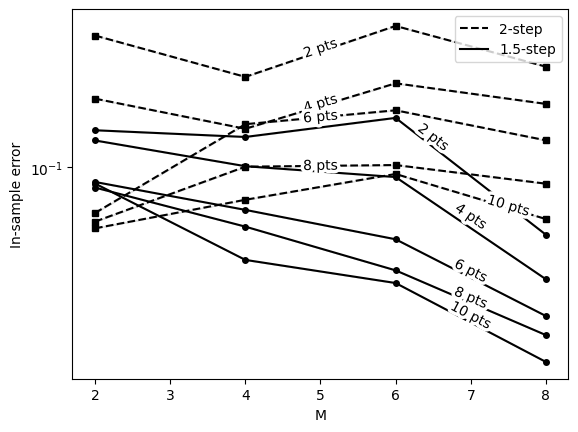

In [6]:
# In sample errors plot
NUM_FUN_LIST = [2,4,6,8]
NUM_RUNS = 3
OBS_PTS_LIST = [2,4,6,8,10]
# plt.title('In sample error: u_new ~ GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
# Colors
c2 = 'black'
c1 = 'black'
# 2-step method plot
for obs_pt in OBS_PTS_LIST:
    # 2 method
    mean_i_opt_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    sd_i_opt_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # Plot 2 method
    plt.plot(ms, mean_i_opt_2, label = f'{obs_pt} pts', marker= 's', linestyle = 'dashed',markersize = 4, color = c2)
    plt.fill_between(ms, mean_i_opt_2 - sd_i_opt_2, mean_i_opt_2 + sd_i_opt_2, alpha=.1, color = c2)
    plt.yscale('log')
    plt.minorticks_off()
# 1-step method plot
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_opt_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    sd_i_opt_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # Plot 1_5 method
    plt.plot(ms, mean_i_opt_1_5, label = f'{obs_pt} pts', marker= 'o',markersize = 4, color = c1)
    plt.fill_between(ms, mean_i_opt_1_5 - sd_i_opt_1_5, mean_i_opt_1_5 + sd_i_opt_1_5, alpha=.1, color = c1)
    plt.yscale('log')
    plt.minorticks_off()

plt.ylabel('In-sample error')
plt.xlabel('M')
# adding labels to the plotlines
xvals_2step = [5]*4 + [7.5]
xvals_1step = [6.5]+[7]*4
xvals = xvals_2step + xvals_1step
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals = xvals)
# add legend box
legend_elements = [Line2D([0], [0], color= c2, linestyle = 'dashed', label='2-step'),
                   Line2D([0], [0], color= c1, label='1.5-step')]
plt.legend(handles = legend_elements, loc = 'upper right')
plt.show()

## In distribution errors

In [66]:
def run_exp_i_dis_err(m,obs_pts,run):
    
    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = xy_pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = 2024
                                        )
                                        )
    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

    # Compute f = Pu for a given u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

    # Define the num of ghost points for each u
    num_grid_points = 10
    num_interior_points = 50

    # Sample collocation points for f using random points different for every function
    xy_ints,xy_bdys = sample_multiple_xy_grids_latin(
            num_functions = m,
            num_interior = num_interior_points,
            x_range = [0,1],
            y_range = [0,1],
            num_grid_x_bdy = num_grid_points,
            num_grid_y_bdy = num_grid_points,
            key = pkey(23)
        )
    
    # # Sample collocation points for f using same uniform grid for every function
    # xy_ints = tuple(build_xy_grid([0,1],[0,1],7,7)[0] for m in range(m))
    # xy_bdys = tuple(build_xy_grid([0,1],[0,1],7,7)[1] for m in range(m))

    xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

    # List of number of observation points per u
    num_obs = [obs_pts]*m

    # Get (X^m, u^m(X^m))
    xy_obs,u_obs = build_u_obs_all(
        num_obs,
        xy_ints,
        xy_bdys,
        vmapped_u_true_functions,
        pkey(5)
    )

    # Build operator features
    def diff_x_op(k,index):
        return get_selected_grad(k,index,0)

    def diff_xx_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,0)

    def diff_y_op(k,index):
        return get_selected_grad(k,index,1)

    def diff_yy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,1),index,1)

    def diff_xy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,1)

    feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_operators = (eval_k,)
    u_models = tuple([CholInducedRKHS(
        xy_all[i],
        u_operators,
        k_u
        ) for i in range(m)])
    
    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = xy_ints

    rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

    all_u_params_init = tuple([
        model.get_fitted_params(obs_loc,obs_val)
        for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(
        model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for xy_int,model,model_params in zip(xy_ints,u_models,all_u_params_init) ])
    
    # P kernel
    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
    k_P_x_part = get_gaussianRBF(0.4)
    @vectorize_kfunc
    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])

    # P object        
    P_model = OperatorModel(k_P)

    # P, u, f object
    collocation_points = xy_ints
    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
    )

    ### Optimize LM
    params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_ints[0]))])
    params,convergence_data = CholeskyLM(
        params_init.copy(),
        EqnModel,
        beta = 1e-8,
        max_iter = 301,
        init_alpha=3,
        line_search_increase_ratio=1.4,
        print_every = 100
    )
    p_adjusted,_ = SVD_LM(params,EqnModel,1e-3,500)

    # Optimized parameters
    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)

    ## Errors

    # Testing grid
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    # Estimated P from 1.5 step method
    model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    
    S_train = model_grid_features_all
    P_func = lambda x: P_model.predict_new(x,S_train,P_sol)

    # Estimated P from 2 step method
    init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
    S_train_2 = init_P_features 
    K = P_model.kernel_function(S_train_2,S_train_2)
    P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)
    P_func2 = lambda x: P_model.predict_new(x,S_train_2,P_params_naive)

    # P[\phi(w)](fine_grid)
    def evaluate_hatP(P_func, w, fine_grid, feature_operators):

        # Build S_test
        w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine_int) for operator in feature_operators]).T
        model_fine_features = jnp.hstack([fine_grid, w_features])
        S_test = model_fine_features


        #P_preds_model_features = P_model.kernel_function(S_test,S_train)@P_sol 
        P_preds = P_func(S_test)
        return P_preds
    
    # In distribution

    M = 3
    kernel_GP = get_gaussianRBF(0.5)
    # Sample M training functions from GP(0,K)
    w_train_functions = GP_sampler(num_samples = M,
                    X = xy_pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    vmapped_w_train_functions = tuple([jax.vmap(w) for w in w_train_functions]) # vmap'ed
    w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_train_functions]) #vmap'ed

    # mean 
    true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
    #pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
    pred1_5 = [
        evaluate_hatP(
        lambda x:P_model.kernel_function(x,S_train)@P_sol,
        w, xy_fine_int,feature_operators) for w in w_train_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in w_train_functions
    ]

    i_dis_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    i_dis_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return i_dis_1_5, i_dis_2

In [67]:
err = {
    '1_5_mthd': {
        '2_obs': {'i_dis': []},
        '4_obs': {'i_dis': []},
        '6_obs': {'i_dis': []},
        '8_obs': {'i_dis': []},
        '10_obs': {'i_dis': []}
                  },
    '2_mthd':   {
        '2_obs': {'i_dis': []},
        '4_obs': {'i_dis': []},
        '6_obs': {'i_dis': []},
        '8_obs': {'i_dis': []},
        '10_obs': {'i_dis': []}
                }
}

In [ ]:
NUM_FUN_LIST = [2,4,6,8]
NUM_RUNS = 3
OBS_PTS_LIST = [2,4,6,8,10]
for obs_pt in OBS_PTS_LIST:
    for m in NUM_FUN_LIST:
        i_dis_1_5 = []
        i_dis_2 = []
        for run in range(NUM_RUNS):
            # Run
            res = run_exp_i_dis_err(m, obs_pt, run)
            # Append
            i_dis_1_5.append(res[0])
            i_dis_2.append(res[1])
        # Append each list    
        err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_2)   
    # Save after
    jnp.save('errors_i_dis/err_rndm_grids_246810_1_5', err)

In [32]:
err = jnp.load('errors_i_dis/err_rndm_grids_246810_1_5.npy', allow_pickle=True).item()

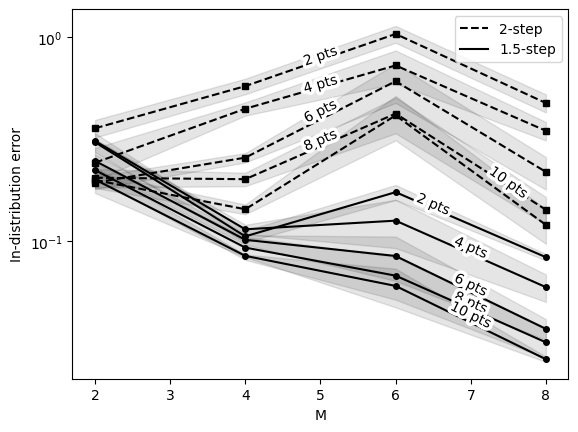

In [33]:
# In distribution errors plot
NUM_FUN_LIST = [2,4,6,8]
NUM_RUNS = 3
OBS_PTS_LIST = [2,4,6,8,10]
# plt.title('In distribution error: u_new ~ GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
# Colors
c2 = 'black'
c1 = 'black'
# 2-step method plot
for obs_pt in OBS_PTS_LIST:
    # 2 method
    mean_i_opt_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_opt_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_i_opt_2, label = f'{obs_pt} pts', marker= 's',linestyle='dashed',markersize = 4, color = c2)
    plt.fill_between(ms, mean_i_opt_2 - sd_i_opt_2, mean_i_opt_2 + sd_i_opt_2, alpha=.1, color = c2)
    plt.yscale('log')
    plt.minorticks_off()
# 1-step method plot
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_opt_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_opt_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # Plot 1_5 method
    plt.plot(ms, mean_i_opt_1_5, label = f'{obs_pt} pts', marker= 'o',markersize = 4, color = c1)
    plt.fill_between(ms, mean_i_opt_1_5 - sd_i_opt_1_5, mean_i_opt_1_5 + sd_i_opt_1_5, alpha=.1, color = c1)
    plt.yscale('log')
    plt.minorticks_off()

plt.ylabel('In-distribution error')
plt.xlabel('M')
# adding labels to the plotlines
xvals_2step = [5]*4 + [7.5]
xvals_1step = [6.5]+[7]*4
xvals = xvals_2step + xvals_1step
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals = xvals)
# add legend box
legend_elements = [Line2D([0], [0], color= c2, linestyle='dashed', label='2-step'),
                   Line2D([0], [0], color= c1, label='1.5-step')]
plt.legend(handles = legend_elements, loc = 'upper right')
plt.show()

## Out of distribution errors

In [11]:
def run_exp_o_dis_err(m,obs_pts,run):
    
    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = xy_pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = 2024
                                        )
                                        )
    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

    # Compute f = Pu for a given u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

    # Define the num of ghost points for each u
    num_grid_points = 10
    num_interior_points = 50

    # Sample collocation points for f using random points different for every function
    xy_ints,xy_bdys = sample_multiple_xy_grids_latin(
            num_functions = m,
            num_interior = num_interior_points,
            x_range = [0,1],
            y_range = [0,1],
            num_grid_x_bdy = num_grid_points,
            num_grid_y_bdy = num_grid_points,
            key = pkey(23)
        )
    
    # # Sample collocation points for f using same uniform grid for every function
    # xy_ints = tuple(build_xy_grid([0,1],[0,1],7,7)[0] for m in range(m))
    # xy_bdys = tuple(build_xy_grid([0,1],[0,1],7,7)[1] for m in range(m))

    xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

    # List of number of observation points per u
    num_obs = [obs_pts]*m

    # Get (X^m, u^m(X^m))
    xy_obs,u_obs = build_u_obs_all(
        num_obs,
        xy_ints,
        xy_bdys,
        vmapped_u_true_functions,
        pkey(5)
    )

    # Build operator features
    def diff_x_op(k,index):
        return get_selected_grad(k,index,0)

    def diff_xx_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,0)

    def diff_y_op(k,index):
        return get_selected_grad(k,index,1)

    def diff_yy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,1),index,1)

    def diff_xy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,1)

    feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_operators = (eval_k,)
    u_models = tuple([CholInducedRKHS(
        xy_all[i],
        u_operators,
        k_u
        ) for i in range(m)])
    
    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = xy_ints

    rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

    all_u_params_init = tuple([
        model.get_fitted_params(obs_loc,obs_val)
        for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(
        model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for xy_int,model,model_params in zip(xy_ints,u_models,all_u_params_init) ])
    
    # P kernel
    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
    k_P_x_part = get_gaussianRBF(0.4)
    @vectorize_kfunc
    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])

    # P object        
    P_model = OperatorModel(k_P)

    # P, u, f object
    collocation_points = xy_ints
    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
    )

    ### Optimize LM
    params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_ints[0]))])
    params,convergence_data = CholeskyLM(
        params_init.copy(),
        EqnModel,
        beta = 1e-8,
        max_iter = 301,
        init_alpha=3,
        line_search_increase_ratio=1.4,
        print_every = 100
    )
    p_adjusted,_ = SVD_LM(params,EqnModel,1e-3,500)

    # Optimized parameters
    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)

    ## Errors

    # Testing grid
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    # Estimated P from 1.5 step method
    model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    
    S_train = model_grid_features_all
    P_func = lambda x: P_model.predict_new(x,S_train,P_sol)

    # Estimated P from 2 step method
    init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
    S_train_2 = init_P_features 
    K = P_model.kernel_function(S_train_2,S_train_2)
    P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)
    P_func2 = lambda x: P_model.predict_new(x,S_train_2,P_params_naive)

    # P[\phi(w)](fine_grid)
    def evaluate_hatP(P_func, w, fine_grid, feature_operators):

        # Build S_test
        w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine_int) for operator in feature_operators]).T
        model_fine_features = jnp.hstack([fine_grid, w_features])
        S_test = model_fine_features


        #P_preds_model_features = P_model.kernel_function(S_test,S_train)@P_sol 
        P_preds = P_func(S_test)
        return P_preds
    
    # Out of distribution
    M = 3
    kernel_GP = get_gaussianRBF(0.2)
    # Sample M test functions from GP(0,K)
    w_test_functions = GP_sampler(num_samples = M,
                    X = xy_pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    vmapped_w_test_functions = tuple([jax.vmap(w) for w in w_test_functions]) # vmap'ed
    w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_test_functions]) #vmap'ed

    # mean 
    true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
    #pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
    pred1_5 = [
        evaluate_hatP(
        lambda x:P_model.kernel_function(x,S_train)@P_sol,
        w, xy_fine_int,feature_operators) for w in w_test_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in w_test_functions
    ]

    o_dis_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    o_dis_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return o_dis_1_5, o_dis_2

In [12]:
err = {
    '1_5_mthd': {
        '2_obs': {'o_dis': []},
        '4_obs': {'o_dis': []},
        '6_obs': {'o_dis': []},
        '8_obs': {'o_dis': []},
        '10_obs': {'o_dis': []}
                  },
    '2_mthd':   {
        '2_obs': {'o_dis': []},
        '4_obs': {'o_dis': []},
        '6_obs': {'o_dis': []},
        '8_obs': {'o_dis': []},
        '10_obs': {'o_dis': []}
                }
}

In [ ]:
NUM_FUN_LIST = [2,4,6,8]
NUM_RUNS = 3
OBS_PTS_LIST = [2,4,6,8,10]
for obs_pt in OBS_PTS_LIST:
    for m in NUM_FUN_LIST:
        o_dis_1_5 = []
        o_dis_2 = []
        for run in range(NUM_RUNS):
            # Run
            res = run_exp_o_dis_err(m, obs_pt, run)
            # Append
            o_dis_1_5.append(res[0])
            o_dis_2.append(res[1])
        # Append each list    
        err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_2)   
    # Save after
    jnp.save('errors_o_dis/err_rndm_grids_246810_1_5', err)

In [35]:
err = jnp.load('errors_o_dis/err_rndm_grids_246810_1_5.npy', allow_pickle=True).item()

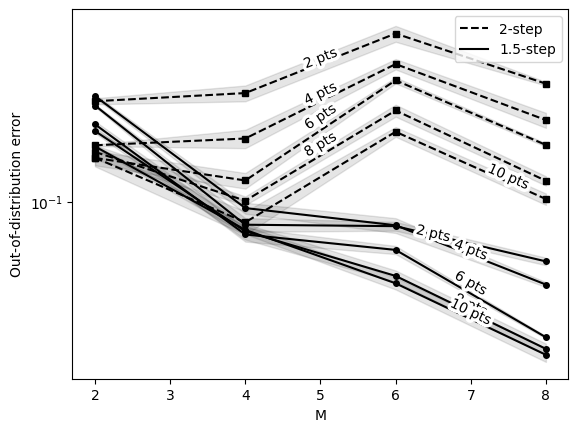

In [37]:
# Out of distribution errors plot
NUM_FUN_LIST = [2,4,6,8]
NUM_RUNS = 3
OBS_PTS_LIST = [2,4,6,8,10]
# plt.title('Out of distribution error: u_new ~ GP(0,RBF(0.2))')
ms = NUM_FUN_LIST
# Colors
c2 = 'black'
c1 = 'black'
# 2-step method plot
for obs_pt in OBS_PTS_LIST:
    # 2 method
    mean_i_opt_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_i_opt_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_i_opt_2, label = f'{obs_pt} pts', marker= 's', linestyle = 'dashed',markersize = 4,color = c2)
    plt.fill_between(ms, mean_i_opt_2 - sd_i_opt_2, mean_i_opt_2 + sd_i_opt_2, alpha=.1, color = c2)
    plt.yscale('log')
    plt.minorticks_off()
# 1-step method plot
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_opt_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_i_opt_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # Plot 1_5 method
    plt.plot(ms, mean_i_opt_1_5, label = f'{obs_pt} pts', marker= 'o',markersize = 4, color = c1)
    plt.fill_between(ms, mean_i_opt_1_5 - sd_i_opt_1_5, mean_i_opt_1_5 + sd_i_opt_1_5, alpha=.1, color = c1)
    plt.yscale('log')
    plt.minorticks_off()

plt.ylabel('Out-of-distribution error')
plt.xlabel('M')
# adding labels to the plotlines
xvals_2step = [5]*4 + [7.5]
xvals_1step = [6.5]+[7]*4
xvals = xvals_2step + xvals_1step
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals = xvals)
# add legend box
legend_elements = [Line2D([0], [0], color= c2, linestyle='dashed',label='2-step'),
                   Line2D([0], [0], color= c1, label='1.5-step')]
plt.legend(handles = legend_elements, loc = 'upper right')
plt.show()